In [1]:
import numpy as np
import pandas as pd
import math

import matplotlib.pyplot as plt
from astropy.io import ascii

from matplotlib.patches import Rectangle

In [17]:
def F_nu(t_p,nu_p,F_nup,nu_sed):
    '''Calculates a Synchrotron Self-Absorbed Spectrum for given input parameters.
    
    Parameters:
    t_p (days): Time of SSA peak - should be single number
    nu_p (GHz): Frequency of SSA peak - should be single number
    F_nup (mJy): Flux of SSA peak - should be single number
    nu (GHz): Frequencies at which you want the SSA spectrum to be calculated at. Likely an array.
    
    Outputs:
    Fnu (mJy): the flux of the SSA. This is an array with values associated with each value of input array nu.
    '''
    
    m = 0.88 #using stAandard model
    p = 3.0 #using standard model
    a = (2*m)+0.5
    b = (p+5-(6*m))/2
    t=t_p
    Fnu = F_nup*1.582*(t/t_p)**a*(nu_sed/nu_p)**(5/2)*(1-np.exp(-(t/t_p)**(-(a+b))*(nu_sed/nu_p)**(-(p+4)/2)))
    
    return Fnu


def SSA_props(t_p,nu_p,F_nup,D_L,f=0.5,alpha=1,vw=100,epsilon_b=0.1):
    '''Calculates Synchroton Self-Absorption properties for given input parameters.
    
    Inputs:
    t_p (days): Time of SSA peak - likely a single number
    nu_p (GHz): Frequency of SSA peak - likely a single number
    F_nup (mJy): Flux of SSA peak - likely a single number
    D (Mpc): angular distance to SN - likely a single number while D_L is the luminosity distance
    f (unitless): filling factor (fraction of emitting region). default is 0.5
    alpha (unitless): ratio charged particles to magnetic field (epsilon_e/epsilon_b). default 1
    v_w (km/s): wind speed. default = 100
    epsilon_b (unitless): fraction of shock energy into B-fields. default = 0.1
    
    Outputs:
    R (cm): radius of material 
    B : magnetic field flux
    E : intermal energy of emitting material
    v (km/s): expansion velocity of material
    M (1d-5 solar masses per year): inferred mass loss rate of progenitor'''
    
    #angular distance
    D = D_L/((1+z)**2)
    
    #Radius
    R = 4.0e14*(alpha)**(-1/19)*(f/0.5)**(-1/19)*(F_nup)**(9/19)*(D)**(18/19)*(nu_p/5)**(-1)

    # Magnetic field flux
    B = 1.1*(alpha)**(-4/19)*(f/0.5)**(-4/19)*(F_nup)**(-2/19)*(D)**(-4/19)*(nu_p/5)

    #Internal energy of the emitting material
    E = (1/epsilon_b)*((B**2)/(8* 3.142))*((4*3.142*f*R**3)/3)

    #expansion velocity in km/s
    v = (R/t_p)*1.1574e-10

    #pre-explosion mass-loss in 1e-5 solar mass per year --wrong
    #M = 1.0*(alpha)**(-8/19)*(epsilon_b/0.1)*(f/0.5)**(-8/19)*(F_nup)**(-4/19)*(D)**(-4/19)*(nu_p/5)*(t_p/10)*(vw/1000)
    
    #pre-explosion mass-loss in 1e-5 solar mass per year ---correct
    M = 0.925*(alpha)**(-8/19)*(epsilon_b/0.1)**(-1)*(f/0.5)**(-8/19)*(F_nup)**(-4/19)*(D)**(-8/19)*(nu_p/5)**(2)*(t_p/10)**(2)*(vw/1000)
   

    return R,B,E,v,M


def taufreefree(M,R,nu):
    '''Calculates the free free optical depth for a given set of parameters.
    
    Inputs:
    M (1d-5 solar masses per year): mass loss rate
    R (cm): radius of emitting material
    nu (GHz): Frequencies at which you want tau-ff to be calculated at. Likely an array.
    
    Outputs:
    tau_ff (unitless): the free-free optical depth, calculated at same frequences as input array nu'''

    Z_ave = 1  # Average metallicity 1= pure H. 5.4 for a massive star
    miu = 1 # mean molecular weight of electrons. 1= pure H  1.9 is for a massive star.
    vw_cgs = 100 * 1e5 # assumed wind velocity in cgs (cm/s). Take this as 1000 * 10^5 for now. (i.e. 1000 km/s in cgs)
    T = 10**4 # temperature of the material absorbing in K.  10^4 is a good starting point. 
        
    M_cgs =  M * 1e-5 * 6.307e+25 #mass loss rate in cgs units
    
    tau_ff = 2.021e25*M_cgs**2*Z_ave/(miu**2*nu**(2.1)*R**3*vw_cgs**2*T**(1.35))  
    
    return tau_ff

def den(M,R):
    vw_cgs = 100 * 1e5
    M_cgs =  M * 1e-5 * 6.307e+25 #mass loss rate in cgs units 
        #density of the CSM
    density = M_cgs/(4*3.142*R**2*vw_cgs)
    
    return density
#freqs,SED = F_nu(1224.288326 , 8,  0.0272)       
#R2,B2,E2,v2,M2 = SSA_props(1224.288326 , 8,  0.0272,880) 
#tauff=taufreefree(M2,R2,freqs)
#tauff=taufreefree(4,3e14,np.array([2,5,7]))
#print(freqs)
#print(tauff)
#print(R2,B2,E2,v2,M2)

Text(0.5, 0.03, '$\\nu$(GHz)')

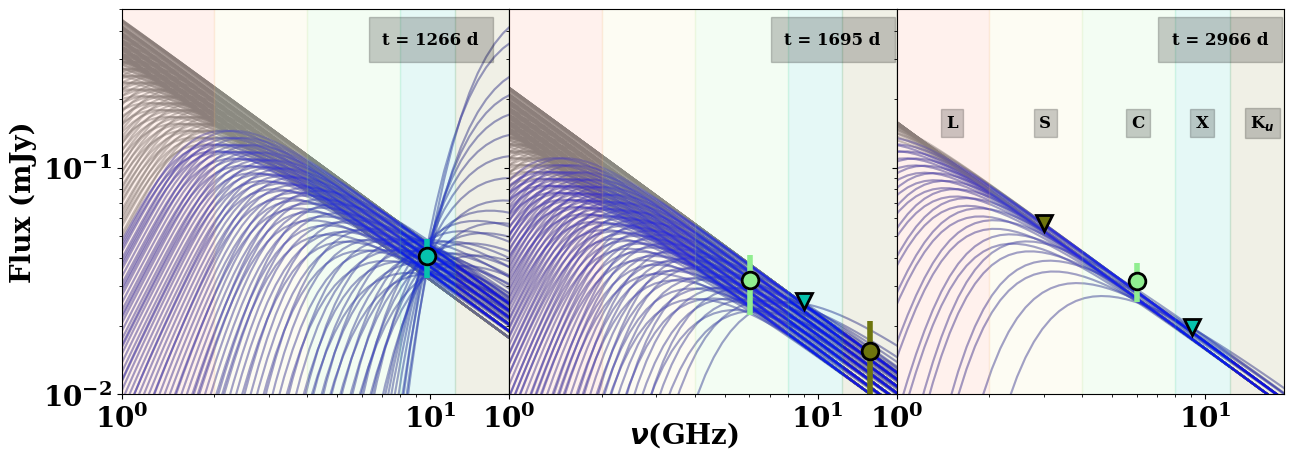

In [18]:

plt.rcParams["font.family"] = "serif"
plt.rcParams.update({'font.size': 15})

from matplotlib import rc,rcParams
rc('font', weight='bold')
plt.rc('xtick',labelsize=20)
plt.rc('ytick',labelsize=20)

fig,subplots = plt.subplots(1, 3,figsize=(15,5), sharex='col', sharey='row',
                        gridspec_kw={'hspace': 0, 'wspace': 0})

#### LEFT: first epoch

subplots[0].set_xscale('log')
subplots[0].set_yscale('log')

file_in = 'PS11aop_grid_e1+5A.csv'
data_plot = ascii.read(file_in)
D_L = 1070.1 # distance to SN in Mpc
date_expl =  55770.562 - 5 #55736.161 #inferred explosion date 
date_obs = 57307.08 # date that radio obs was taken
redshift = 0.218 # redshift of object
z=0.218
t_p = (date_obs - date_expl)/(1+redshift) # time of observation in days #1261.509031#

file_inc = 'PS11aop_grid_e2+5A.csv'
data_plotc = ascii.read(file_inc)

file_inb = 'PS11aop_grid_e3+5A.csv'
data_plotb = ascii.read(file_inb)
index2 = np.where(data_plotb['RuledOut'] == 'False')[0]
data_plot2b = data_plotb[index2]

#Allowed epoch 2
indexc = np.where(data_plotc['RuledOut'] == 'False')[0]
data_plot2 = data_plotc[indexc]
index2b = np.where(data_plot2['Radius'] < np.max(data_plot2b['Radius']))[0]
data_plot2d = data_plot2[index2b]
index3b = np.where(data_plot2d['v_shock'] > np.min(data_plot2b['v_shock']))[0]
data_plot2e = data_plot2d[index3b]


#Allowed epoch 1 by constrained epoch 2
indexa = np.where(data_plot['RuledOut'] == 'False')[0]
data_plota = data_plot[indexa]
index2a = np.where(data_plota['Radius'] < np.max(data_plot2e['Radius']))[0]
data_plot1a = data_plota[index2a]
index3a = np.where(data_plot1a['v_shock'] > np.min(data_plot2e['v_shock']))[0]
data_plot1aa = data_plot1a[index3a]

Fcalc = data_plot1aa['F_peak']#[0:100:2]
nucalc = data_plot1aa['nu_peak']#[0:100:2]
nu_sed=np.logspace(np.log10(0.1),np.log10(50),num=100)


###Cycle over the SEDs to show######
for i in range(len(Fcalc)):
    #calculate SSA
    SSA_sed = F_nu(t_p,nucalc[i],Fcalc[i],nu_sed)
    
    #calculate Mass loss rate, Radius, velocity, etc.
    R,B,E,v,M = SSA_props(t_p,nucalc[i],Fcalc[i],D_L)

    #calculate tau_ff
    tauff = taufreefree(M,R,nu_sed)
        
    #Correct SED for FFA:
    SSA_FFA_sed = SSA_sed*np.exp(-tauff)
    
    #Plot it:
    subplots[0].plot(nu_sed,SSA_FFA_sed,'gray',zorder=1,alpha=0.5)

##overplot the SEDs with v_shock < 20,000km/s
Fcalc_v = data_plot1aa['F_peak'][data_plot1aa['v_shock'] <= 20000]
nucalc_v = data_plot1aa['nu_peak'][data_plot1aa['v_shock'] <= 20000]

###Cycle over the SEDs to show######
for i in range(len(Fcalc_v)):
    #calculate SSA
    SSA_sedv = F_nu(t_p,nucalc_v[i],Fcalc_v[i],nu_sed)
    
    #calculate Mass loss rate, Radius, velocity, etc.
    Ra,Ba,Ea,va,Ma = SSA_props(t_p,nucalc_v[i],Fcalc_v[i],D_L)

    #calculate tau_ff
    tauffv = taufreefree(Ma,Ra,nu_sed)
        
    #Correct SED for FFA:
    SSA_FFA_sedv = SSA_sedv*np.exp(-tauffv)
    
    #Plot it:
    subplots[0].plot(nu_sed,SSA_FFA_sedv,'b',zorder=1,alpha=0.2)
    
#Overplot the data:
subplots[0].errorbar(9.77,0.0405,0.0078,fmt ='o',color='xkcd:turquoise',markersize=12,elinewidth=4,markeredgecolor='k',markeredgewidth=2)#'ro', markersize=10)
#subplots[0].text(1.1,0.04,'Allowed',color = 'b',fontsize=15,bbox={'facecolor': 'b', 'alpha': 0.2, 'pad': 5})
#subplots[0].text(1.1,0.03,'Not Allowed',color='r',fontsize=15,bbox={'facecolor': 'r', 'alpha': 0.2, 'pad': 5})
r1e = Rectangle((1,5e-3),1,1,color='coral',alpha=0.1,zorder=1)
r2e = Rectangle((2,5e-3),2,1,color='khaki',alpha=0.1,zorder=1)
r3e = Rectangle((4,5e-3),4,1,color='lightgreen',alpha=0.1,zorder=1)
r4e = Rectangle((8,5e-3),4,1,color='xkcd:turquoise',alpha=0.1,zorder=1)
r5e = Rectangle((12,5e-3),6,1,color='xkcd:olive',alpha=0.1,zorder=1)
r6e = Rectangle((18,5e-3),8.5,1,color='#3696e3',alpha=0.1,zorder=1)
r7e = Rectangle((26.5,5e-3),13.5,1,color='#3784c6',alpha=0.1,zorder=1)
r8e = Rectangle((40,5e-3),10,1,color='#38618c',alpha=0.1,zorder=1)

subplots[0].add_patch(r1e)
subplots[0].add_patch(r2e)
subplots[0].add_patch(r3e)
subplots[0].add_patch(r4e)
subplots[0].add_patch(r5e)
subplots[0].add_patch(r6e)
subplots[0].add_patch(r7e)
subplots[0].add_patch(r8e)

#subplots[0].text(22,1e-1,'K',fontsize=12,bbox={'facecolor': 'k', 'alpha': 0.2, 'pad': 4})
#subplots[0].text(32,1e-1,'Ka',fontsize=12,bbox={'facecolor': 'k', 'alpha': 0.2, 'pad': 4})
#subplots[0].text(45,1e-1,'Q',fontsize=12,bbox={'facecolor': 'k', 'alpha': 0.2, 'pad': 4})

#subplots[0,0].xlabel(r'$\nu$ (GHz)', fontsize=20) #Log$_{10}$ t$_{rest}$(days)($\u03BD$ /5 GHz)', fontsize=14)
subplots[0].set_ylabel('Flux (mJy)', fontsize=20, fontweight ='bold') 
#subplots[0].title.set_text('PS1-11aop 2015B Observations')   
subplots[0].title.set_fontsize(16) 
#subplots[0].set_ylim(8e-3,1e-1)
subplots[0].set_ylim(1e-2,0.5)
subplots[0].set_xlim(1,18)
#subplots[0].set_xlim(3,50)
subplots[0].text(7,0.35,'t = 1266 d',fontsize=12,fontweight='bold',bbox={'facecolor': 'k', 'alpha': 0.2, 'pad': 10})

#subplots[0].text(3.2,0.8,r'$R \sim (2-22) \times 10^{16}$ cm',fontsize=11,fontweight='bold')
#subplots[0].text(3.2,0.45,r'$v_{sh} \sim (2-20) \times 10^3$ km s$^{-1}$',fontsize=11,fontweight='bold')
#subplots[0].text(3.2,0.30,r'$\rho_{CSM}$ $\sim 10^{-22} - 10^{-20}$ g cm$^{-3}$',fontsize=11,fontweight='bold')
#subplots[0].text(3.2,0.22,r'$\.{M} \sim (2-26) \times 10^{-5}$ M$_{\odot}$ yr$^{-1}$',fontsize=11,fontweight='bold')

#subplots[0].text(3.2,0.8,r'$R = 2.07-21.56\times 10^{16}$ cm',fontsize=11,fontweight='bold')
#subplots[0].text(3.2,0.45,r'$v_{sh} = 1.89-19.72\times 10^3$ km s$^{-1}$',fontsize=11,fontweight='bold')
#subplots[0].text(3.2,0.30,r'$\rho_{CSM} = 0.02-24.75\times 10^{-20}$ g cm$^{-3}$',fontsize=11,fontweight='bold')
#subplots[0].text(3.2,0.27,r'$\.{M} = 2-26\times 10^{-5}$ M$_{\odot}$ yr$^{-1}$',fontsize=11,fontweight='bold')


#NEW
#1.7275550006705815 26.450863693180743
#1893.7543639432865 19718.210849807165
#1.8647381738953237e-22 2.474143466098678e-19
#2.0708158507681804e+16 2.1561816228132867e+17

####MIDDLE:Second Epoch

subplots[1].set_xscale('log')
subplots[1].set_yscale('log')


D_L = 1070.1 # distance to SN in Mpc
date_expl =  55770.562 - 5 #55736.161 #inferred explosion date
date_obs = 57829.76513 # date that radio obs was taken
redshift = 0.218 # redshift of object
z=0.218
t_p = (date_obs - date_expl)/(1+redshift) # time of observation in days #1261.509031#
file_inc = 'PS11aop_grid_e2+5A.csv'
data_plotc = ascii.read(file_inc)

file_inb = 'PS11aop_grid_e3+5A.csv'
data_plotb = ascii.read(file_inb)
index2 = np.where(data_plotb['RuledOut'] == 'False')[0]
data_plot2b = data_plotb[index2]

#Allowed
indexc = np.where(data_plotc['RuledOut'] == 'False')[0]
data_plot2 = data_plotc[indexc]
index2b = np.where(data_plot2['Radius'] < np.max(data_plot2b['Radius']))[0]
data_plot23 = data_plot2[index2b]
index3b = np.where(data_plot23['v_shock'] > np.min(data_plot2b['v_shock']))[0]
data_plot24 = data_plot23[index3b]

Fcalc = data_plot24['F_peak']#[0:100:5]
nucalc = data_plot24['nu_peak']#[0:100:5]
nu_sed=np.logspace(np.log10(0.1),np.log10(50),num=100)

###Cycle over the SEDs to show######
for i in range(len(Fcalc)):
    #calculate SSA
    SSA_sed = F_nu(t_p,nucalc[i],Fcalc[i],nu_sed)
    
    #calculate Mass loss rate, Radius, velocity, etc.
    R,B,E,v,M = SSA_props(t_p,nucalc[i],Fcalc[i],D_L)

    #calculate tau_ff
    tauff = taufreefree(M,R,nu_sed)
        
    #Correct SED for FFA:
    SSA_FFA_sed = SSA_sed*np.exp(-tauff)
    
    #Plot it:
    subplots[1].plot(nu_sed,SSA_FFA_sed,'gray',zorder=1,alpha=0.5)

##overplot the SEDs with v_shock < 20,000km/s
Fcalc_v = data_plot24['F_peak'][data_plot24['v_shock'] <= 20000]
nucalc_v = data_plot24['nu_peak'][data_plot24['v_shock'] <= 20000]

###Cycle over the SEDs to show######
for i in range(len(Fcalc_v)):
    #calculate SSA
    SSA_sedv = F_nu(t_p,nucalc_v[i],Fcalc_v[i],nu_sed)
    
    #calculate Mass loss rate, Radius, velocity, etc.
    Ra,Ba,Ea,va,Ma = SSA_props(t_p,nucalc_v[i],Fcalc_v[i],D_L)

    #calculate tau_ff
    tauffv = taufreefree(Ma,Ra,nu_sed)
        
    #Correct SED for FFA:
    SSA_FFA_sedv = SSA_sedv*np.exp(-tauffv)
    
    #Plot it:
    subplots[1].plot(nu_sed,SSA_FFA_sedv,'b',zorder=1,alpha=0.2)
    
#Overplot the data:
subplots[1].errorbar(6.05,0.0318,0.0095,fmt ='o',color='lightgreen',markersize=12,elinewidth=4,markeredgecolor='k',markeredgewidth=2)#'ro', markersize=10)
subplots[1].plot(9.02,0.0258, 'v',color='xkcd:turquoise',markersize=12,markeredgecolor='k',markeredgewidth=2)
subplots[1].errorbar(14.75,0.0155, 0.0056,fmt='o',color='xkcd:olive',markersize=12,elinewidth=4,markeredgecolor='k',markeredgewidth=2)#, markersize=10)


r1d = Rectangle((1,5e-3),1,1,color='coral',alpha=0.1,zorder=1)
r2d = Rectangle((2,5e-3),2,1,color='khaki',alpha=0.1,zorder=1)
r3d = Rectangle((4,5e-3),4,1,color='lightgreen',alpha=0.1,zorder=1)
r4d = Rectangle((8,5e-3),4,1,color='xkcd:turquoise',alpha=0.1,zorder=1)
r5d = Rectangle((12,5e-3),6,1,color='xkcd:olive',alpha=0.1,zorder=1)
subplots[1].add_patch(r1d)
subplots[1].add_patch(r2d)
subplots[1].add_patch(r3d)
subplots[1].add_patch(r4d)
subplots[1].add_patch(r5d)

subplots[1].title.set_fontsize(16) 
#subplots[1].set_ylim(8e-3,1e-1)
subplots[1].set_ylim(1e-2,0.5)
subplots[1].set_xlim(1,18)
subplots[1].text(7.8,0.35,'t = 1695 d',fontsize=12,fontweight='bold',bbox={'facecolor': 'k', 'alpha': 0.2, 'pad': 10})

#subplots[1].text(1.2,0.8,r'$R \sim (3-29) \times 10^{16}$ cm',fontsize=11,fontweight='bold')
#subplots[1].text(1.2,0.45,r'$v_{sh} \sim (2-20) \times 10^3$ km s$^{-1}$',fontsize=11,fontweight='bold')
#subplots[1].text(1.2,0.30,r'$\rho_{CSM}$ $\sim 10^{-23} - 10^{-20}$ g cm$^{-3}$',fontsize=11,fontweight='bold')
#subplots[1].text(1.2,0.22,r'$\.{M} \sim (2 - 12) \times 10^{-5}$ M$_{\odot}$ yr$^{-1}$',fontsize=11,fontweight='bold')


#NEW
#1.6141202072445873 12.032175779673452
#1890.2385884001442 19609.457914970237
#9.82467120943005e-23 7.881778854940376e-20
#2.7678228526358144e+16 2.871357408420725e+17

####LEFT:Third Epoch

subplots[2].set_xscale('log')
subplots[2].set_yscale('log')


D_L = 1070.1 # distance to SN in Mpc
date_expl =  55770.562 - 5 #55736.161 #inferred explosion date 
date_obs = 59378.446209  # date that radio obs was taken
redshift = 0.218 # redshift of object
z=0.218
t_p = (date_obs - date_expl)/(1+redshift) # time of observation in days #1261.509031#
file_inb = 'PS11aop_grid_e3+5A.csv'
data_plot3b = ascii.read(file_inb)

#Allowed
index3b = np.where(data_plot3b['RuledOut'] == 'False')[0]
data_plot2b = data_plot3b[index3b]

Fcalc = data_plot2b['F_peak']#[0:10]
nucalc = data_plot2b['nu_peak']#[0:10]
nu_sed=np.logspace(np.log10(0.1),np.log10(50),num=100)
#print(nu_sed)

###Cycle over the SEDs to show######
for i in range(len(Fcalc)):
    #calculate SSA
    SSA_sed = F_nu(t_p,nucalc[i],Fcalc[i],nu_sed)
    
    #calculate Mass loss rate, Radius, velocity, etc.
    R,B,E,v,M = SSA_props(t_p,nucalc[i],Fcalc[i],D_L)

    #calculate tau_ff
    tauff = taufreefree(M,R,nu_sed)
        
    #Correct SED for FFA:
    SSA_FFA_sed = SSA_sed*np.exp(-tauff)
    
    #Plot it:
    subplots[2].plot(nu_sed,SSA_FFA_sed,'gray',zorder=1,alpha=0.5)
    
##overplot the SEDs with v_shock < 20,000km/s
Fcalc_v = data_plot2b['F_peak'][data_plot2b['v_shock'] <= 20000]
nucalc_v = data_plot2b['nu_peak'][data_plot2b['v_shock'] <= 20000]

###Cycle over the SEDs to show######
for i in range(len(Fcalc_v)):
    #calculate SSA
    SSA_sedv = F_nu(t_p,nucalc_v[i],Fcalc_v[i],nu_sed)
    
    #calculate Mass loss rate, Radius, velocity, etc.
    Ra,Ba,Ea,va,Ma = SSA_props(t_p,nucalc_v[i],Fcalc_v[i],D_L)

    #calculate tau_ff
    tauffv = taufreefree(Ma,Ra,nu_sed)
        
    #Correct SED for FFA:
    SSA_FFA_sedv = SSA_sedv*np.exp(-tauffv)
    
    #Plot it:
    subplots[2].plot(nu_sed,SSA_FFA_sedv,'b',zorder=1,alpha=0.2)
    
#Overplot the data:
#plt.plot(3.0,0.405, 'kv', markersize=10)
subplots[2].errorbar(5.998364,0.0317,0.0063,fmt ='o',color='lightgreen',markersize=12,elinewidth=4,markeredgecolor='k',markeredgewidth=2)#'ro', markersize=10)
subplots[2].plot(9.048039,0.019847, 'v',color='xkcd:turquoise',markersize=12,markeredgecolor='k',markeredgewidth=2)
#subplots[2].errorbar(2.998683,0.1274, 0.0201,fmt='o',color='xkcd:olive',markersize=12,elinewidth=4,markeredgecolor='k',markeredgewidth=2)#, markersize=10)
subplots[2].errorbar(2.998683,0.0567,fmt='v',color='xkcd:olive',markersize=12,elinewidth=4,markeredgecolor='k',markeredgewidth=2)#, markersize=10)

#Different VLA bands
r1a = Rectangle((1,5e-3),1,1,color='coral',alpha=0.1,zorder=1)
r2a = Rectangle((2,5e-3),2,1,color='khaki',alpha=0.1,zorder=1)
r3a = Rectangle((4,5e-3),4,1,color='lightgreen',alpha=0.1,zorder=1)
r4a = Rectangle((8,5e-3),4,1,color='xkcd:turquoise',alpha=0.1,zorder=1)
r5a = Rectangle((12,5e-3),6,1,color='xkcd:olive',alpha=0.1,zorder=1)

subplots[2].add_patch(r1a)
subplots[2].add_patch(r2a)
subplots[2].add_patch(r3a)
subplots[2].add_patch(r4a)
subplots[2].add_patch(r5a)
#plot the bands 
subplots[2].text(1.45,1.5e-1,'L',fontsize=12,bbox={'facecolor': 'k', 'alpha': 0.2, 'pad': 4})
subplots[2].text(2.9,1.5e-1,'S',fontsize=12,bbox={'facecolor': 'k', 'alpha': 0.2, 'pad': 4})
subplots[2].text(5.75,1.5e-1,'C',fontsize=12,bbox={'facecolor': 'k', 'alpha': 0.2, 'pad': 4})
subplots[2].text(9.3,1.5e-1,'X',fontsize=12,bbox={'facecolor': 'k', 'alpha': 0.2, 'pad': 4})
subplots[2].text(14,1.5e-1,r'K$_u$',fontsize=12,bbox={'facecolor': 'k', 'alpha': 0.2, 'pad': 4})

subplots[2].title.set_fontsize(16) 
#subplots[2].set_ylim(60e-4,1e-1)
subplots[2].set_ylim(1e-2,0.5)
subplots[2].set_xlim(1,18)
subplots[2].text(7.8,0.35,'t = 2966 d',fontsize=12,fontweight='bold',bbox={'facecolor': 'k', 'alpha': 0.2, 'pad': 10})

#subplots[2].text(1.2,0.8,r'$R \sim (4-48) \times 10^{16}$ cm',fontsize=11,fontweight='bold')
#subplots[2].text(1.2,0.45,r'$v_{sh} \sim (2-19) \times 10^3$ km s$^{-1}$',fontsize=11,fontweight='bold')
#subplots[2].text(1.2,0.30,r'$\rho_{CSM}$ $ \sim 10^{-23} - 10^{-20}$ g cm$^{-3}$',fontsize=11,fontweight='bold')
#subplots[2].text(1.2,0.22,r'$\.{M} \sim (2-14) \times 10^{-5}$ M$_{\odot}$ yr$^{-1}$',fontsize=11,fontweight='bold')


#NEW
#1.8519293176024456 13.855672091663479
#1641.4709305105812 18734.8173741703
#4.031211505554048e-23 3.9289030346625476e-20
#4.206844629371578e+16 4.8014536467161395e+17

fig.text(0.5, 0.03,r'$\nu$(GHz)',fontsize=20, va='center',ha ='center',fontweight ='bold')

#plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
#plt.tight_layout()
#plt.savefig('SEDps11aop5.png',dpi = 500, transparent = True)
#plt.show()


In [19]:
#-5 days explosion date epoch 1
indexv1 = (data_plot1aa['v_shock'] <= 20000)
print(np.min(data_plot1aa[indexv1]['Mdot']), np.max(data_plot1aa[indexv1]['Mdot']) ) 
print(np.min(data_plot1aa[indexv1]['v_shock']), np.max(data_plot1aa[indexv1]['v_shock']) ) 
print(np.min(data_plot1aa[indexv1]['den']), np.max(data_plot1aa[indexv1]['den']) ) 
print(np.min(data_plot1aa[indexv1]['Radius']), np.max(data_plot1aa[indexv1]['Radius']) ) 

17.7671569576574 664.0269747759771
4920.3578885390425 19718.210849807165
1.9178026637457686e-21 6.07577056678394e-19
5.3803995391579976e+16 2.1561816228132867e+17


In [20]:
#-5 days explosion date epoch 2
indexv2 = (data_plot24['v_shock'] <= 20000)
print(np.min(data_plot24[indexv2]['Mdot']), np.max(data_plot24[indexv2]['Mdot']))  
print(np.min(data_plot24[indexv2]['v_shock']), np.max(data_plot24[indexv2]['v_shock'])  )
print(np.min(data_plot24[indexv2]['den']), np.max(data_plot24[indexv2]['den'])  )
print(np.min(data_plot24[indexv2]['Radius']), np.max(data_plot24[indexv2]['Radius']) )

14.625394203987447 176.37916957711693
4597.0744488581495 19609.457914970237
8.902043894721364e-22 1.953428620180834e-19
6.731365973005022e+16 2.871357408420725e+17


In [21]:
#-5.5 days explosion date, epoch 3
indexv3 = (data_plot2b['v_shock'] <= 20000)
print(np.min(data_plot2b[indexv3]['Mdot']), np.max(data_plot2b[indexv3]['Mdot']) ) 
print(np.min(data_plot2b[indexv3]['v_shock']), np.max(data_plot2b[indexv3]['v_shock']) ) 
print(np.min(data_plot2b[indexv3]['den']), np.max(data_plot2b[indexv3]['den']) ) 
print(np.min(data_plot2b[indexv3]['Radius']), np.max(data_plot2b[indexv3]['Radius']) ) 

20.719657503613742 203.4267639721311
4280.565418464607 18734.8173741703
4.51017870529967e-22 8.482344741484655e-20
1.0970449312641941e+17 4.8014536467161395e+17


<ipython-input-169-5bc6105aed58>:84: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  Fcalc_v = data_plot1aa['F_peak'][[data_plot1aa['v_shock'] <= 20000]]
<ipython-input-169-5bc6105aed58>:85: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  nucalc_v = data_plot1aa['nu_peak'][[data_plot1aa['v_shock'] <= 20000]]
<ipython-input-169-5bc6105aed58>:207: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.ar

Text(0.5, 0.03, '$\\nu$(GHz)')

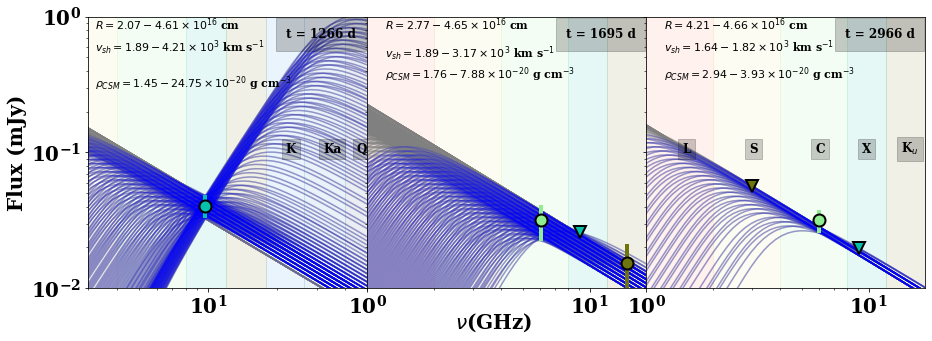

In [169]:
#plt.rc('text', usetex=True)
#plt.rcParams['text.latex.preamble']=[r"\usepackage{amsmath}"]

plt.rcParams["font.family"] = "serif"
plt.rcParams.update({'font.size': 15})

from matplotlib import rc,rcParams
rc('font', weight='bold')
plt.rc('xtick',labelsize=20)
plt.rc('ytick',labelsize=20)

#figure, subplots = plt.subplots(1, 2, figsize=(18,10))
#figure.rcParams.update({'font.size': 10})
#fig = fig.add_subplot(111) 
fig,subplots = plt.subplots(1, 3,figsize=(15,5), sharex='col', sharey='row',
                        gridspec_kw={'hspace': 0, 'wspace': 0})

#### LEFT: first epoch

subplots[0].set_xscale('log')
subplots[0].set_yscale('log')

file_in = 'PS11aop_grid_e1+5A.csv'
data_plot = ascii.read(file_in)
D_L = 1070.1 # distance to SN in Mpc
date_expl =  55770.562 - 5 #55736.161 #inferred explosion date 
date_obs = 57307.08 # date that radio obs was taken
redshift = 0.218 # redshift of object
z=0.218
t_p = (date_obs - date_expl)/(1+redshift) # time of observation in days #1261.509031#

file_inc = 'PS11aop_grid_e2+5A.csv'
data_plotc = ascii.read(file_inc)

file_inb = 'PS11aop_grid_e3+5A.csv'
data_plotb = ascii.read(file_inb)
index2 = np.where(data_plotb['RuledOut'] == 'False')[0]
data_plot2b = data_plotb[index2]

#Allowed epoch 2
indexc = np.where(data_plotc['RuledOut'] == 'False')[0]
data_plot2 = data_plotc[indexc]
index2b = np.where(data_plot2['Radius'] < np.max(data_plot2b['Radius']))[0]
data_plot2d = data_plot2[index2b]
index3b = np.where(data_plot2d['v_shock'] > np.min(data_plot2b['v_shock']))[0]
data_plot2e = data_plot2d[index3b]


#Allowed epoch 1 by constrained epoch 2
indexa = np.where(data_plot['RuledOut'] == 'False')[0]
data_plota = data_plot[indexa]
index2a = np.where(data_plota['Radius'] < np.max(data_plot2e['Radius']))[0]
data_plot1a = data_plota[index2a]
index3a = np.where(data_plot1a['v_shock'] > np.min(data_plot2e['v_shock']))[0]
data_plot1aa = data_plot1a[index3a]
#index4 = np.where(data_plot['Mdot'] > 0.85)[0]
#data_plot = data_plot[index4]
#index5 = np.where(data_plot['Mdot'] < 1.5)[0]
#data_plot = data_plot[index5]

Fcalc = data_plot1aa['F_peak']#[0:100:2]
nucalc = data_plot1aa['nu_peak']#[0:100:2]
nu_sed=np.logspace(np.log10(0.1),np.log10(50),num=100)


###Cycle over the SEDs to show######
for i in range(len(Fcalc)):
    #calculate SSA
    SSA_sed = F_nu(t_p,nucalc[i],Fcalc[i],nu_sed)
    
    #calculate Mass loss rate, Radius, velocity, etc.
    R,B,E,v,M = SSA_props(t_p,nucalc[i],Fcalc[i],D_L)

    #calculate tau_ff
    tauff = taufreefree(M,R,nu_sed)
        
    #Correct SED for FFA:
    SSA_FFA_sed = SSA_sed*np.exp(-tauff)
    
    #Plot it:
    subplots[0].plot(nu_sed,SSA_FFA_sed,'gray',zorder=1,alpha=0.5)

##overplot the SEDs with v_shock < 20,000km/s
Fcalc_v = data_plot1aa['F_peak'][[data_plot1aa['v_shock'] <= 20000]]
nucalc_v = data_plot1aa['nu_peak'][[data_plot1aa['v_shock'] <= 20000]]

###Cycle over the SEDs to show######
for i in range(len(Fcalc_v)):
    #calculate SSA
    SSA_sedv = F_nu(t_p,nucalc_v[i],Fcalc_v[i],nu_sed)
    
    #calculate Mass loss rate, Radius, velocity, etc.
    Ra,Ba,Ea,va,Ma = SSA_props(t_p,nucalc_v[i],Fcalc_v[i],D_L)

    #calculate tau_ff
    tauffv = taufreefree(Ma,Ra,nu_sed)
        
    #Correct SED for FFA:
    SSA_FFA_sedv = SSA_sedv*np.exp(-tauffv)
    
    #Plot it:
    subplots[0].plot(nu_sed,SSA_FFA_sedv,'b',zorder=1,alpha=0.2)
    
#Overplot the data:
subplots[0].errorbar(9.77,0.0405,0.0078,fmt ='o',color='xkcd:turquoise',markersize=12,elinewidth=4,markeredgecolor='k',markeredgewidth=2)#'ro', markersize=10)
#subplots[0].text(1.1,0.04,'Allowed',color = 'b',fontsize=15,bbox={'facecolor': 'b', 'alpha': 0.2, 'pad': 5})
#subplots[0].text(1.1,0.03,'Not Allowed',color='r',fontsize=15,bbox={'facecolor': 'r', 'alpha': 0.2, 'pad': 5})
r1e = Rectangle((1,5e-3),1,1,color='coral',alpha=0.1,zorder=1)
r2e = Rectangle((2,5e-3),2,1,color='khaki',alpha=0.1,zorder=1)
r3e = Rectangle((4,5e-3),4,1,color='lightgreen',alpha=0.1,zorder=1)
r4e = Rectangle((8,5e-3),4,1,color='xkcd:turquoise',alpha=0.1,zorder=1)
r5e = Rectangle((12,5e-3),6,1,color='xkcd:olive',alpha=0.1,zorder=1)
r6e = Rectangle((18,5e-3),8.5,1,color='#3696e3',alpha=0.1,zorder=1)
r7e = Rectangle((26.5,5e-3),13.5,1,color='#3784c6',alpha=0.1,zorder=1)
r8e = Rectangle((40,5e-3),10,1,color='#38618c',alpha=0.1,zorder=1)

subplots[0].add_patch(r1e)
subplots[0].add_patch(r2e)
subplots[0].add_patch(r3e)
subplots[0].add_patch(r4e)
subplots[0].add_patch(r5e)
subplots[0].add_patch(r6e)
subplots[0].add_patch(r7e)
subplots[0].add_patch(r8e)

subplots[0].text(22,1e-1,'K',fontsize=12,bbox={'facecolor': 'k', 'alpha': 0.2, 'pad': 4})
subplots[0].text(32,1e-1,'Ka',fontsize=12,bbox={'facecolor': 'k', 'alpha': 0.2, 'pad': 4})
subplots[0].text(45,1e-1,'Q',fontsize=12,bbox={'facecolor': 'k', 'alpha': 0.2, 'pad': 4})

#subplots[0,0].xlabel(r'$\nu$ (GHz)', fontsize=20) #Log$_{10}$ t$_{rest}$(days)($\u03BD$ /5 GHz)', fontsize=14)
subplots[0].set_ylabel('Flux (mJy)', fontsize=20, fontweight ='bold') 
#subplots[0].title.set_text('PS1-11aop 2015B Observations')   
subplots[0].title.set_fontsize(16) 
#subplots[0].set_ylim(8e-3,1e-1)
subplots[0].set_ylim(1e-2,1)
#subplots[0].set_xlim(1,18)
subplots[0].set_xlim(3,50)
subplots[0].text(22,0.7,'t = 1266 d',fontsize=12,fontweight='bold',bbox={'facecolor': 'k', 'alpha': 0.2, 'pad': 10})
subplots[0].text(3.2,0.55,r'$v_{sh} = 1.89-4.21\times 10^3$ km s$^{-1}$',fontsize=11,fontweight='bold')
subplots[0].text(3.2,0.3,r'$\rho_{CSM} = 1.45-24.75\times 10^{-20}$ g cm$^{-3}$',fontsize=11,fontweight='bold')
subplots[0].text(3.2,0.8,r'$R = 2.07-4.61\times 10^{16}$ cm',fontsize=11,fontweight='bold')

#NEW
#Mdot = 6.134963178635112 26.459443179016514
#v_shock = 1893.1403132759326 4215.704913143672
#den = 1.4478076187447238e-20 2.47494596839385e-19
#Radius = 2.0708158507681804e+16 4.611358437131747e+16


#constrained epoch 1 for -5.5 days, #min Mdot = 6.191779411528108, max Mdot = 24.613365873108947, min vshock =2196.31, max vshock =4378.9753
#min Radius = 2.4024447551647108e+16cm, max Radius= 4.78995215665958e+16 cm

####MIDDLE:Second Epoch

subplots[1].set_xscale('log')
subplots[1].set_yscale('log')


D_L = 1070.1 # distance to SN in Mpc
date_expl =  55770.562 - 5 #55736.161 #inferred explosion date
date_obs = 57829.76513 # date that radio obs was taken
redshift = 0.218 # redshift of object
z=0.218
t_p = (date_obs - date_expl)/(1+redshift) # time of observation in days #1261.509031#
file_inc = 'PS11aop_grid_e2+5A.csv'
data_plotc = ascii.read(file_inc)

file_inb = 'PS11aop_grid_e3+5A.csv'
data_plotb = ascii.read(file_inb)
index2 = np.where(data_plotb['RuledOut'] == 'False')[0]
data_plot2b = data_plotb[index2]

#Allowed
indexc = np.where(data_plotc['RuledOut'] == 'False')[0]
data_plot2 = data_plotc[indexc]
index2b = np.where(data_plot2['Radius'] < np.max(data_plot2b['Radius']))[0]
data_plot23 = data_plot2[index2b]
index3b = np.where(data_plot23['v_shock'] > np.min(data_plot2b['v_shock']))[0]
data_plot24 = data_plot23[index3b]

#print(np.max(data_plot1aa['Radius']))
#print(np.max(data_plot24['Radius']))
#print(np.max(data_plot2b['Radius']))

Fcalc = data_plot24['F_peak']#[0:100:5]
nucalc = data_plot24['nu_peak']#[0:100:5]
nu_sed=np.logspace(np.log10(0.1),np.log10(50),num=100)

###Cycle over the SEDs to show######
for i in range(len(Fcalc)):
    #calculate SSA
    SSA_sed = F_nu(t_p,nucalc[i],Fcalc[i],nu_sed)
    
    #calculate Mass loss rate, Radius, velocity, etc.
    R,B,E,v,M = SSA_props(t_p,nucalc[i],Fcalc[i],D_L)

    #calculate tau_ff
    tauff = taufreefree(M,R,nu_sed)
        
    #Correct SED for FFA:
    SSA_FFA_sed = SSA_sed*np.exp(-tauff)
    
    #Plot it:
    subplots[1].plot(nu_sed,SSA_FFA_sed,'gray',zorder=1,alpha=0.5)

##overplot the SEDs with v_shock < 20,000km/s
Fcalc_v = data_plot24['F_peak'][[data_plot24['v_shock'] <= 20000]]
nucalc_v = data_plot24['nu_peak'][[data_plot24['v_shock'] <= 20000]]

###Cycle over the SEDs to show######
for i in range(len(Fcalc_v)):
    #calculate SSA
    SSA_sedv = F_nu(t_p,nucalc_v[i],Fcalc_v[i],nu_sed)
    
    #calculate Mass loss rate, Radius, velocity, etc.
    Ra,Ba,Ea,va,Ma = SSA_props(t_p,nucalc_v[i],Fcalc_v[i],D_L)

    #calculate tau_ff
    tauffv = taufreefree(Ma,Ra,nu_sed)
        
    #Correct SED for FFA:
    SSA_FFA_sedv = SSA_sedv*np.exp(-tauffv)
    
    #Plot it:
    subplots[1].plot(nu_sed,SSA_FFA_sedv,'b',zorder=1,alpha=0.2)
    
#Overplot the data:
#plt.plot(3.0,0.405, 'kv', markersize=10)
subplots[1].errorbar(6.05,0.0318,0.0095,fmt ='o',color='lightgreen',markersize=12,elinewidth=4,markeredgecolor='k',markeredgewidth=2)#'ro', markersize=10)
subplots[1].plot(9.02,0.0258, 'v',color='xkcd:turquoise',markersize=12,markeredgecolor='k',markeredgewidth=2)
subplots[1].errorbar(14.75,0.0155, 0.0056,fmt='o',color='xkcd:olive',markersize=12,elinewidth=4,markeredgecolor='k',markeredgewidth=2)#, markersize=10)


r1d = Rectangle((1,5e-3),1,1,color='coral',alpha=0.1,zorder=1)
r2d = Rectangle((2,5e-3),2,1,color='khaki',alpha=0.1,zorder=1)
r3d = Rectangle((4,5e-3),4,1,color='lightgreen',alpha=0.1,zorder=1)
r4d = Rectangle((8,5e-3),4,1,color='xkcd:turquoise',alpha=0.1,zorder=1)
r5d = Rectangle((12,5e-3),6,1,color='xkcd:olive',alpha=0.1,zorder=1)
subplots[1].add_patch(r1d)
subplots[1].add_patch(r2d)
subplots[1].add_patch(r3d)
subplots[1].add_patch(r4d)
subplots[1].add_patch(r5d)


#subplots[1].set_xlabel(r'$\nu$ (GHz)', fontsize=20) #Log$_{10}$ t$_{rest}$(days)($\u03BD$ /5 GHz)', fontsize=14)
#subplots[0,1].set_ylabel('Flux (mJy)', fontsize=20) 
#subplots[1].title.set_text('PS1-11aop 2017A Observations') 
subplots[1].title.set_fontsize(16) 
#subplots[1].set_ylim(8e-3,1e-1)
subplots[1].set_ylim(1e-2,1)
subplots[1].set_xlim(1,18)
subplots[1].text(7.8,0.7,'t = 1695 d',fontsize=12,fontweight='bold',bbox={'facecolor': 'k', 'alpha': 0.2, 'pad': 10})

subplots[1].text(1.2,0.5,r'$v_{sh} = 1.89-3.17\times 10^3$ km s$^{-1}$',fontsize=11,fontweight='bold')
subplots[1].text(1.2,0.35,r'$\rho_{CSM} = 1.76-7.88\times 10^{-20}$ g cm$^{-3}$',fontsize=11,fontweight='bold')
subplots[1].text(1.2,0.8,r'$R = 2.77-4.65\times 10^{16}$ cm',fontsize=11,fontweight='bold')
#min Mdot =7.041936980012711,  max Mdot= 9.906490930768486, min vshock=2190.7755283332067,max vshock = 3319.3191300949834
#min radius = 3.2086676144317716e+16 cm, max radius = 4.861562335782906e+16

#NEW
#Mdot = 7.384619788771754 12.035090264106888
#v_shock =  1889.7808377044305 3171.697966305886
#den = 1.7620236203054442e-20 7.883688012702126e-20
#Radius = 2.7678228526358144e+16 4.645352486198187e+16


####LEFT:Third Epoch

subplots[2].set_xscale('log')
subplots[2].set_yscale('log')


D_L = 1070.1 # distance to SN in Mpc
date_expl =  55770.562 - 5 #55736.161 #inferred explosion date 
date_obs = 59378.446209  # date that radio obs was taken
redshift = 0.218 # redshift of object
z=0.218
t_p = (date_obs - date_expl)/(1+redshift) # time of observation in days #1261.509031#
file_inb = 'PS11aop_grid_e3+5A.csv'
data_plot3b = ascii.read(file_inb)

#Allowed
index3b = np.where(data_plot3b['RuledOut'] == 'False')[0]
data_plot2b = data_plot3b[index3b]


#print(np.max(data_plot2b['Radius']))


Fcalc = data_plot2b['F_peak']#[0:10]
nucalc = data_plot2b['nu_peak']#[0:10]
nu_sed=np.logspace(np.log10(0.1),np.log10(50),num=100)
#print(nu_sed)

###Cycle over the SEDs to show######
for i in range(len(Fcalc)):
    #calculate SSA
    SSA_sed = F_nu(t_p,nucalc[i],Fcalc[i],nu_sed)
    
    #calculate Mass loss rate, Radius, velocity, etc.
    R,B,E,v,M = SSA_props(t_p,nucalc[i],Fcalc[i],D_L)

    #calculate tau_ff
    tauff = taufreefree(M,R,nu_sed)
    #print(tauff)    
    #Correct SED for FFA:
    SSA_FFA_sed = SSA_sed*np.exp(-tauff)
    
    #Plot it:
    subplots[2].plot(nu_sed,SSA_FFA_sed,'gray',zorder=1,alpha=0.5)
    #print(nu_sed,SSA_FFA_sed)
##overplot the SEDs with v_shock < 20,000km/s
Fcalc_v = data_plot2b['F_peak'][[data_plot2b['v_shock'] <= 20000]]
nucalc_v = data_plot2b['nu_peak'][[data_plot2b['v_shock'] <= 20000]]

###Cycle over the SEDs to show######
for i in range(len(Fcalc_v)):
    #calculate SSA
    SSA_sedv = F_nu(t_p,nucalc_v[i],Fcalc_v[i],nu_sed)
    
    #calculate Mass loss rate, Radius, velocity, etc.
    Ra,Ba,Ea,va,Ma = SSA_props(t_p,nucalc_v[i],Fcalc_v[i],D_L)

    #calculate tau_ff
    tauffv = taufreefree(Ma,Ra,nu_sed)
        
    #Correct SED for FFA:
    SSA_FFA_sedv = SSA_sedv*np.exp(-tauffv)
    
    #Plot it:
    subplots[2].plot(nu_sed,SSA_FFA_sedv,'b',zorder=1,alpha=0.2)
    
#Overplot the data:
#plt.plot(3.0,0.405, 'kv', markersize=10)
subplots[2].errorbar(5.998364,0.0317,0.0063,fmt ='o',color='lightgreen',markersize=12,elinewidth=4,markeredgecolor='k',markeredgewidth=2)#'ro', markersize=10)
subplots[2].plot(9.048039,0.019847, 'v',color='xkcd:turquoise',markersize=12,markeredgecolor='k',markeredgewidth=2)
#subplots[2].errorbar(2.998683,0.1274, 0.0201,fmt='o',color='xkcd:olive',markersize=12,elinewidth=4,markeredgecolor='k',markeredgewidth=2)#, markersize=10)
subplots[2].errorbar(2.998683,0.0567,fmt='v',color='xkcd:olive',markersize=12,elinewidth=4,markeredgecolor='k',markeredgewidth=2)#, markersize=10)

#Different VLA bands
r1a = Rectangle((1,5e-3),1,1,color='coral',alpha=0.1,zorder=1)
r2a = Rectangle((2,5e-3),2,1,color='khaki',alpha=0.1,zorder=1)
r3a = Rectangle((4,5e-3),4,1,color='lightgreen',alpha=0.1,zorder=1)
r4a = Rectangle((8,5e-3),4,1,color='xkcd:turquoise',alpha=0.1,zorder=1)
r5a = Rectangle((12,5e-3),6,1,color='xkcd:olive',alpha=0.1,zorder=1)

subplots[2].add_patch(r1a)
subplots[2].add_patch(r2a)
subplots[2].add_patch(r3a)
subplots[2].add_patch(r4a)
subplots[2].add_patch(r5a)
#plot the bands 
subplots[2].text(1.45,1e-1,'L',fontsize=12,bbox={'facecolor': 'k', 'alpha': 0.2, 'pad': 4})
subplots[2].text(2.9,1e-1,'S',fontsize=12,bbox={'facecolor': 'k', 'alpha': 0.2, 'pad': 4})
subplots[2].text(5.75,1e-1,'C',fontsize=12,bbox={'facecolor': 'k', 'alpha': 0.2, 'pad': 4})
subplots[2].text(9.3,1e-1,'X',fontsize=12,bbox={'facecolor': 'k', 'alpha': 0.2, 'pad': 4})
subplots[2].text(14,1e-1,r'K$_u$',fontsize=12,bbox={'facecolor': 'k', 'alpha': 0.2, 'pad': 4})

#subplots[1].set_xlabel(r'$\nu$ (GHz)', fontsize=20) #Log$_{10}$ t$_{rest}$(days)($\u03BD$ /5 GHz)', fontsize=14)
#subplots[0,1].set_ylabel('Flux (mJy)', fontsize=20) 
#subplots[1].title.set_text('PS1-11aop 2017A Observations') 
subplots[2].title.set_fontsize(16) 
#subplots[2].set_ylim(60e-4,1e-1)
subplots[2].set_ylim(1e-2,1)
subplots[2].set_xlim(1,18)
subplots[2].text(7.8,0.7,'t = 2966 d',fontsize=12,fontweight='bold',bbox={'facecolor': 'k', 'alpha': 0.2, 'pad': 10})

subplots[2].text(1.2,0.55,r'$v_{sh} = 1.64-1.82\times 10^3$ km s$^{-1}$',fontsize=11,fontweight='bold')
subplots[2].text(1.2,0.35,r'$\rho_{CSM} = 2.94-3.93\times 10^{-20}$ g cm$^{-3}$',fontsize=11,fontweight='bold')
subplots[2].text(1.2,0.8,r'$R = 4.21-4.66\times 10^{16}$ cm',fontsize=11,fontweight='bold')

#Mdot = 12.735179790905603 13.857589627804987
#v_shock =  1641.243792897257 1818.989507435901
#den = 2.9399138198361335e-20 3.9294467696409446e-20
#Radius = 4.206844629371578e+16 4.662443369690785e+16

#epoch 3 for 5.5days ,#min Mdot = 6.836011235940209, max Mdot = 11.072736621254554, min vshock=2034.1101429576038, max vshock = 3548.5430881078705
#min radius = 2.97921135939517e+16, max radius = 5.197289789835402e+16
fig.text(0.5, 0.03,r'$\nu$(GHz)',fontsize=20, va='center',ha ='center',fontweight ='bold')

#plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
#plt.tight_layout()
#plt.savefig('SEDps11aop5.png',dpi = 500, transparent = True)
#plt.show()


In [170]:
D_L = 1070.1 # distance to SN in Mpc
date_expl =  55770.562 - 5 #55736.161 #inferred explosion date 
date_obs = 59378.446209  # date that radio obs was taken
redshift = 0.218 # redshift of object
z=0.218
t_p = (date_obs - date_expl)/(1+redshift) # time of observation in days #1261.509031#
file_inb = 'PS11aop_grid_e3+5A.csv'
data_plot3b = ascii.read(file_inb)

#Allowed
index3b = np.where(data_plot3b['RuledOut'] == 'False')[0]
data_plot2b = data_plot3b[index3b]

Fcalc = data_plot2b['F_peak'][1]
nucalc = data_plot2b['nu_peak'][1]
nu_sed= 5.998364 # 9.048039

    #calculate SSA
SSA_sed = F_nu(t_p,nucalc,Fcalc,nu_sed)
    
    #calculate Mass loss rate, Radius, velocity, etc.
R,B,E,v,M = SSA_props(t_p,nucalc,Fcalc,D_L)

    #calculate tau_ff
tauff = taufreefree(M,R,nu_sed)
print(tauff)    
    #Correct SED for FFA:
    #SSA_FFA_sed = SSA_sed*np.exp(-tauff)
    
    #Plot it:
    #subplots[2].plot(nu_sed,SSA_FFA_sed,'b',zorder=1,alpha=0.5)
    #print(nu_sed,SSA_FFA_sed)

0.008392225826269804


In [171]:
0.1/0.0035

28.571428571428573

In [ ]:
For one of the SEDs
0.019174711414803407-without log for 5.99GHz
0.008087 -without log, for 9.04GHz

the second one
0.01189576 -without log, for 5.99GHz
0.00501760 -without log for 9.04GHz

In [22]:
#1893.1403132759326 4215.704913143672 #5.5
#1810.2186950451023 3972.270918349801 #100
#(1893.1403132759326-1810.2186950451023)/1893.1403132759326, (4215.704913143672-3972.270918349801)/4215.704913143672
#(0.04580751400800458, 0.06128333132298044) #percentage difference between 100days parameters and 5.5 days

#1.4478076187447238e-20 2.47494596839385e-19 #5.5
#density=1.536534092736192e-20 2.5505738024891537e-19 #100
#(1.536534092736192e-20-1.4478076187447238e-20)/1.4478076187447238e-20,(2.5505738024891537e-19-2.47494596839385e-19)/2.47494596839385e-19
#(0.061283331322980326, 0.03055736774099485)

#Radius=2.0708158507681804e+16 4.611358437131747e+16 #5.5
#Radius=2.1014597000140364e+16 4.611358437131747e+16 #100
#(2.1014597000140364e+16-2.0708158507681804e+16)/2.0708158507681804e+16,(4.611358437131747e+16-4.611358437131747e+16)/4.611358437131747e+16
#(0.014797959574478096, 0.0)

(0.014797959574478096, 0.0)

In [35]:
#time of radio observations with respect to rest-frame g-max

t_sn = 55770.562 - 5
t_obs = 59378.45  #57829.7651 second epoch #57307.08  #first epoch
z = 0.218

t_phase = (t_obs - t_sn)/(1+z)
t_phase

2966.2463054187183

In [145]:
#-5 days explosion date epoch 1
print(np.min(data_plot1aa['Mdot']), np.max(data_plot1aa['Mdot']) ) 
print(np.min(data_plot1aa['v_shock']), np.max(data_plot1aa['v_shock']) ) 
print(np.min(data_plot1aa['den']), np.max(data_plot1aa['den']) ) 
print(np.min(data_plot1aa['Radius']), np.max(data_plot1aa['Radius']) ) 

#data_plot1aa[70:90]

0.12783517897911292 26.450863693180743
1893.7543639432865 462256.9561479058
2.510755741091465e-26 2.474143466098678e-19
2.0708158507681804e+16 5.054768718397537e+18


In [141]:
#-5 days explosion date epoch 1
indexv1 = (data_plot1aa['v_shock'] <= 20000)
print(np.min(data_plot1aa[indexv1]['Mdot']), np.max(data_plot1aa[indexv1]['Mdot']) ) 
print(np.min(data_plot1aa[indexv1]['v_shock']), np.max(data_plot1aa[indexv1]['v_shock']) ) 
print(np.min(data_plot1aa[indexv1]['den']), np.max(data_plot1aa[indexv1]['den']) ) 
print(np.min(data_plot1aa[indexv1]['Radius']), np.max(data_plot1aa[indexv1]['Radius']) ) 

1.7275550006705815 26.450863693180743
1893.7543639432865 19718.210849807165
1.8647381738953237e-22 2.474143466098678e-19
2.0708158507681804e+16 2.1561816228132867e+17


In [146]:
#-5. days explosion date, epoch 2

print(np.min(data_plot24['Mdot']), np.max(data_plot24['Mdot']))  
print(np.min(data_plot24['v_shock']), np.max(data_plot24['v_shock'])  )
print(np.min(data_plot24['den']), np.max(data_plot24['den'])  )
print(np.min(data_plot24['Radius']), np.max(data_plot24['Radius']) )


0.08645766418957332 12.032175779673452
1890.2385884001442 671051.5120933007
4.493710669139416e-27 7.881778854940376e-20
2.7678228526358144e+16 9.826017317949673e+18


In [133]:
#-5 days explosion date epoch 2
indexv2 = (data_plot24['v_shock'] <= 20000)
print(np.min(data_plot24[indexv2]['Mdot']), np.max(data_plot24[indexv2]['Mdot']))  
print(np.min(data_plot24[indexv2]['v_shock']), np.max(data_plot24[indexv2]['v_shock'])  )
print(np.min(data_plot24[indexv2]['den']), np.max(data_plot24[indexv2]['den'])  )
print(np.min(data_plot24[indexv2]['Radius']), np.max(data_plot24[indexv2]['Radius']) )

1.6141202072445873 12.032175779673452
1890.2385884001442 19609.457914970237
9.82467120943005e-23 7.881778854940376e-20
2.7678228526358144e+16 2.871357408420725e+17


In [147]:
#-5.5 days explosion date, epoch 3
print(np.min(data_plot2b['Mdot']), np.max(data_plot2b['Mdot']) ) 
print(np.min(data_plot2b['v_shock']), np.max(data_plot2b['v_shock']) ) 
print(np.min(data_plot2b['den']), np.max(data_plot2b['den']) ) 
print(np.min(data_plot2b['Radius']), np.max(data_plot2b['Radius']) ) 


0.14911643883674114 13.855672091663479
1641.4709305105812 396285.6220581062
7.254692315470112e-27 3.9289030346625476e-20
4.206844629371578e+16 1.0156208129337762e+19


In [135]:
#-5.5 days explosion date, epoch 3
indexv3 = (data_plot2b['v_shock'] <= 20000)
print(np.min(data_plot2b[indexv3]['Mdot']), np.max(data_plot2b[indexv3]['Mdot']) ) 
print(np.min(data_plot2b[indexv3]['v_shock']), np.max(data_plot2b[indexv3]['v_shock']) ) 
print(np.min(data_plot2b[indexv3]['den']), np.max(data_plot2b[indexv3]['den']) ) 
print(np.min(data_plot2b[indexv3]['Radius']), np.max(data_plot2b[indexv3]['Radius']) ) 

1.8519293176024456 13.855672091663479
1641.4709305105812 18734.8173741703
4.031211505554048e-23 3.9289030346625476e-20
4.206844629371578e+16 4.8014536467161395e+17


## -100 days post explosion

5.054768718397537e+18
9.826017317949673e+18
1.0156208129337762e+19
1.0156208129337762e+19


Text(0.5, 0.03, '$\\nu$(GHz)')

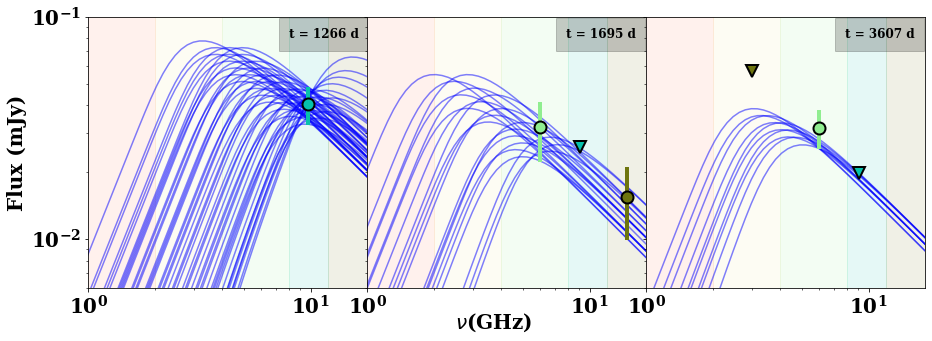

In [13]:
#plt.rc('text', usetex=True)
#plt.rcParams['text.latex.preamble']=[r"\usepackage{amsmath}"]

plt.rcParams["font.family"] = "serif"
plt.rcParams.update({'font.size': 15})

from matplotlib import rc,rcParams
rc('font', weight='bold')
plt.rc('xtick',labelsize=20)
plt.rc('ytick',labelsize=20)

#figure, subplots = plt.subplots(1, 2, figsize=(18,10))
#figure.rcParams.update({'font.size': 10})
#fig = fig.add_subplot(111) 
fig,subplots = plt.subplots(1, 3,figsize=(15,5), sharex='col', sharey='row',
                        gridspec_kw={'hspace': 0, 'wspace': 0})

#### LEFT: first epoch

subplots[0].set_xscale('log')
subplots[0].set_yscale('log')

file_in = 'PS11aop_grid_e1+100A.csv'
data_plot = ascii.read(file_in)
D_L = 1070.1 # distance to SN in Mpc
date_expl =  55770.562 - 100 #55736.161 #inferred explosion date 
date_obs = 57307.08 # date that radio obs was taken
redshift = 0.218 # redshift of object
z=0.218
t_p = (date_obs - date_expl)/(1+redshift) # time of observation in days #1261.509031#

file_inc = 'PS11aop_grid_e2+100A.csv'
data_plotc = ascii.read(file_inc)

file_inb = 'PS11aop_grid_e3+100A.csv'
data_plotb = ascii.read(file_inb)
index2 = np.where(data_plotb['RuledOut'] == 'False')[0]
data_plot2b = data_plotb[index2]

#Allowed epoch 2
indexc = np.where(data_plotc['RuledOut'] == 'False')[0]
data_plot2 = data_plotc[indexc]
index2b = np.where(data_plot2['Radius'] < np.max(data_plot2b['Radius']))[0]
data_plot2d = data_plot2[index2b]
index3b = np.where(data_plot2d['v_shock'] > np.min(data_plot2b['v_shock']))[0]
data_plot2e = data_plot2d[index3b]


#Allowed epoch 1 by constrained epoch 2
indexa = np.where(data_plot['RuledOut'] == 'False')[0]
data_plota = data_plot[indexa]
index2a = np.where(data_plota['Radius'] < np.max(data_plot2e['Radius']))[0]
data_plot1a = data_plota[index2a]
index3a = np.where(data_plot1a['v_shock'] > np.min(data_plot2e['v_shock']))[0]
data_plot1aa = data_plot1a[index3a]
#index4 = np.where(data_plot['Mdot'] > 0.85)[0]
#data_plot = data_plot[index4]
#index5 = np.where(data_plot['Mdot'] < 1.5)[0]
#data_plot = data_plot[index5]

Fcalc = data_plot1aa['F_peak'][0:100:2]
nucalc = data_plot1aa['nu_peak'][0:100:2]
nu_sed=np.logspace(np.log10(0.1),np.log10(50),num=100)

###Cycle over the SEDs to show######
for i in range(len(Fcalc)):
    #calculate SSA
    SSA_sed = F_nu(t_p,nucalc[i],Fcalc[i],nu_sed)
    
    #calculate Mass loss rate, Radius, velocity, etc.
    R,B,E,v,M = SSA_props(t_p,nucalc[i],Fcalc[i],D_L)

    #calculate tau_ff
    tauff = taufreefree(M,R,nu_sed)
        
    #Correct SED for FFA:
    SSA_FFA_sed = SSA_sed*np.exp(-tauff)
    
    #Plot it:
    subplots[0].plot(nu_sed,SSA_FFA_sed,'b',zorder=1,alpha=0.5)


#Overplot the data:
subplots[0].errorbar(9.77,0.0405,0.0078,fmt ='o',color='xkcd:turquoise',markersize=12,elinewidth=4,markeredgecolor='k',markeredgewidth=2)#'ro', markersize=10)
#subplots[0].text(1.1,0.04,'Allowed',color = 'b',fontsize=15,bbox={'facecolor': 'b', 'alpha': 0.2, 'pad': 5})
#subplots[0].text(1.1,0.03,'Not Allowed',color='r',fontsize=15,bbox={'facecolor': 'r', 'alpha': 0.2, 'pad': 5})
r1e = Rectangle((1,5e-3),1,0.095,color='coral',alpha=0.1,zorder=1)
r2e = Rectangle((2,5e-3),2,0.095,color='khaki',alpha=0.1,zorder=1)
r3e = Rectangle((4,5e-3),4,0.095,color='lightgreen',alpha=0.1,zorder=1)
r4e = Rectangle((8,5e-3),4,0.095,color='xkcd:turquoise',alpha=0.1,zorder=1)
r5e = Rectangle((12,5e-3),6,0.095,color='xkcd:olive',alpha=0.1,zorder=1)
subplots[0].add_patch(r1e)
subplots[0].add_patch(r2e)
subplots[0].add_patch(r3e)
subplots[0].add_patch(r4e)
subplots[0].add_patch(r5e)


#subplots[0,0].xlabel(r'$\nu$ (GHz)', fontsize=20) #Log$_{10}$ t$_{rest}$(days)($\u03BD$ /5 GHz)', fontsize=14)
subplots[0].set_ylabel('Flux (mJy)', fontsize=20, fontweight ='bold') 
#subplots[0].title.set_text('PS1-11aop 2015B Observations')   
subplots[0].title.set_fontsize(16) 
subplots[0].set_ylim(8e-3,1e-1)
subplots[0].set_xlim(1,18)
subplots[0].text(8,0.08,'t = 1266 d',fontsize=12,fontweight='bold',bbox={'facecolor': 'k', 'alpha': 0.2, 'pad': 10})
#subplots[0].text(1.2,0.065,r'$v_{sh} = 1.89-4.21\times 10^3$ km s$^{-1}$',fontsize=11,fontweight='bold')
#subplots[0].text(1.2,0.05,r'$\rho_{CSM} = 1.45-24.75\times 10^{-20}$ g cm$^{-3}$',fontsize=11,fontweight='bold')
#subplots[0].text(1.2,0.08,r'$R = 2.07-4.61\times 10^{16}$ cm',fontsize=11,fontweight='bold')


####MIDDLE:Second Epoch

subplots[1].set_xscale('log')
subplots[1].set_yscale('log')


D_L = 1070.1 # distance to SN in Mpc
date_expl =  55770.562 - 100 #55736.161 #inferred explosion date
date_obs = 57829.76513 # date that radio obs was taken
redshift = 0.218 # redshift of object
z=0.218
t_p = (date_obs - date_expl)/(1+redshift) # time of observation in days #1261.509031#
file_inc = 'PS11aop_grid_e2+100A.csv'
data_plotc = ascii.read(file_inc)

file_inb = 'PS11aop_grid_e3+100A.csv'
data_plotb = ascii.read(file_inb)
index2 = np.where(data_plotb['RuledOut'] == 'False')[0]
data_plot2b = data_plotb[index2]

#Allowed
indexc = np.where(data_plotc['RuledOut'] == 'False')[0]
data_plot2 = data_plotc[indexc]
index2b = np.where(data_plot2['Radius'] < np.max(data_plot2b['Radius']))[0]
data_plot23 = data_plot2[index2b]
index3b = np.where(data_plot23['v_shock'] > np.min(data_plot2b['v_shock']))[0]
data_plot24 = data_plot23[index3b]

print(np.max(data_plot1aa['Radius']))
print(np.max(data_plot24['Radius']))
print(np.max(data_plot2b['Radius']))

Fcalc = data_plot24['F_peak'][0:100:5]
nucalc = data_plot24['nu_peak'][0:100:5]
nu_sed=np.logspace(np.log10(0.1),np.log10(50),num=100)

###Cycle over the SEDs to show######
for i in range(len(Fcalc)):
    #calculate SSA
    SSA_sed = F_nu(t_p,nucalc[i],Fcalc[i],nu_sed)
    
    #calculate Mass loss rate, Radius, velocity, etc.
    R,B,E,v,M = SSA_props(t_p,nucalc[i],Fcalc[i],D_L)

    #calculate tau_ff
    tauff = taufreefree(M,R,nu_sed)
        
    #Correct SED for FFA:
    SSA_FFA_sed = SSA_sed*np.exp(-tauff)
    
    #Plot it:
    subplots[1].plot(nu_sed,SSA_FFA_sed,'b',zorder=1,alpha=0.5)


#Overplot the data:
#plt.plot(3.0,0.405, 'kv', markersize=10)
subplots[1].errorbar(6.0,0.0318,0.0095,fmt ='o',color='lightgreen',markersize=12,elinewidth=4,markeredgecolor='k',markeredgewidth=2)#'ro', markersize=10)
subplots[1].plot(9.02,0.0258, 'v',color='xkcd:turquoise',markersize=12,markeredgecolor='k',markeredgewidth=2)
subplots[1].errorbar(14.74,0.0155, 0.0056,fmt='o',color='xkcd:olive',markersize=12,elinewidth=4,markeredgecolor='k',markeredgewidth=2)#, markersize=10)


r1d = Rectangle((1,5e-3),1,0.095,color='coral',alpha=0.1,zorder=1)
r2d = Rectangle((2,5e-3),2,0.095,color='khaki',alpha=0.1,zorder=1)
r3d = Rectangle((4,5e-3),4,0.095,color='lightgreen',alpha=0.1,zorder=1)
r4d = Rectangle((8,5e-3),4,0.095,color='xkcd:turquoise',alpha=0.1,zorder=1)
r5d = Rectangle((12,5e-3),6,0.095,color='xkcd:olive',alpha=0.1,zorder=1)
subplots[1].add_patch(r1d)
subplots[1].add_patch(r2d)
subplots[1].add_patch(r3d)
subplots[1].add_patch(r4d)
subplots[1].add_patch(r5d)


#subplots[1].set_xlabel(r'$\nu$ (GHz)', fontsize=20) #Log$_{10}$ t$_{rest}$(days)($\u03BD$ /5 GHz)', fontsize=14)
#subplots[0,1].set_ylabel('Flux (mJy)', fontsize=20) 
#subplots[1].title.set_text('PS1-11aop 2017A Observations') 
subplots[1].title.set_fontsize(16) 
subplots[1].set_ylim(8e-3,1e-1)
subplots[1].set_xlim(1,18)
subplots[1].text(7.8,0.08,'t = 1695 d',fontsize=12,fontweight='bold',bbox={'facecolor': 'k', 'alpha': 0.2, 'pad': 10})

#subplots[1].text(1.2,0.06,r'$v_{sh} = 1.89-3.17\times 10^3$ km s$^{-1}$',fontsize=11,fontweight='bold')
#subplots[1].text(1.2,0.045,r'$\rho_{CSM} = 1.76-7.88\times 10^{-20}$ g cm$^{-3}$',fontsize=11,fontweight='bold')
#subplots[1].text(1.2,0.08,r'$R = 2.77-4.65\times 10^{16}$ cm',fontsize=11,fontweight='bold')

####LEFT:Third Epoch

subplots[2].set_xscale('log')
subplots[2].set_yscale('log')


D_L = 1070.1 # distance to SN in Mpc
date_expl =  55770.562 - 100 #55736.161 #inferred explosion date 
date_obs = 59378.446209  # date that radio obs was taken
redshift = 0.218 # redshift of object
z=0.218
t_p = (date_obs - date_expl)/(1+redshift) # time of observation in days #1261.509031#
file_inb = 'PS11aop_grid_e3+100A.csv'
data_plot3b = ascii.read(file_inb)

#Allowed
index3b = np.where(data_plot3b['RuledOut'] == 'False')[0]
data_plot2b = data_plot3b[index3b]


print(np.max(data_plot2b['Radius']))


Fcalc = data_plot2b['F_peak'][0:10]
nucalc = data_plot2b['nu_peak'][0:10]
nu_sed=np.logspace(np.log10(0.1),np.log10(50),num=100)


###Cycle over the SEDs to show######
for i in range(len(Fcalc)):
    #calculate SSA
    SSA_sed = F_nu(t_p,nucalc[i],Fcalc[i],nu_sed)
    
    #calculate Mass loss rate, Radius, velocity, etc.
    R,B,E,v,M = SSA_props(t_p,nucalc[i],Fcalc[i],D_L)

    #calculate tau_ff
    tauff = taufreefree(M,R,nu_sed)
        
    #Correct SED for FFA:
    SSA_FFA_sed = SSA_sed*np.exp(-tauff)
    
    #Plot it:
    subplots[2].plot(nu_sed,SSA_FFA_sed,'b',zorder=1,alpha=0.5)

#Overplot the data:
#plt.plot(3.0,0.405, 'kv', markersize=10)
subplots[2].errorbar(5.998364,0.0317,0.0063,fmt ='o',color='lightgreen',markersize=12,elinewidth=4,markeredgecolor='k',markeredgewidth=2)#'ro', markersize=10)
subplots[2].plot(9.048039,0.019847, 'v',color='xkcd:turquoise',markersize=12,markeredgecolor='k',markeredgewidth=2)
#subplots[2].errorbar(2.998683,0.1274, 0.0201,fmt='o',color='xkcd:olive',markersize=12,elinewidth=4,markeredgecolor='k',markeredgewidth=2)#, markersize=10)
subplots[2].errorbar(2.998683,0.0567,fmt='v',color='xkcd:olive',markersize=12,elinewidth=4,markeredgecolor='k',markeredgewidth=2)#, markersize=10)


r1a = Rectangle((1,5e-3),1,0.095,color='coral',alpha=0.1,zorder=1)
r2a = Rectangle((2,5e-3),2,0.095,color='khaki',alpha=0.1,zorder=1)
r3a = Rectangle((4,5e-3),4,0.095,color='lightgreen',alpha=0.1,zorder=1)
r4a = Rectangle((8,5e-3),4,0.095,color='xkcd:turquoise',alpha=0.1,zorder=1)
r5a = Rectangle((12,5e-3),6,0.095,color='xkcd:olive',alpha=0.1,zorder=1)
subplots[2].add_patch(r1a)
subplots[2].add_patch(r2a)
subplots[2].add_patch(r3a)
subplots[2].add_patch(r4a)
subplots[2].add_patch(r5a)


#subplots[1].set_xlabel(r'$\nu$ (GHz)', fontsize=20) #Log$_{10}$ t$_{rest}$(days)($\u03BD$ /5 GHz)', fontsize=14)
#subplots[0,1].set_ylabel('Flux (mJy)', fontsize=20) 
#subplots[1].title.set_text('PS1-11aop 2017A Observations') 
subplots[2].title.set_fontsize(16) 
subplots[2].set_ylim(60e-4,1e-1)
subplots[2].set_xlim(1,18)
subplots[2].text(7.8,0.08,'t = 3607 d',fontsize=12,fontweight='bold',bbox={'facecolor': 'k', 'alpha': 0.2, 'pad': 10})

#subplots[2].text(1.2,0.065,r'$v_{sh} = 1.64-1.82\times 10^3$ km s$^{-1}$',fontsize=11,fontweight='bold')
#subplots[2].text(1.2,0.045,r'$\rho_{CSM} = 2.94-3.93\times 10^{-20}$ g cm$^{-3}$',fontsize=11,fontweight='bold')
#subplots[2].text(1.2,0.08,r'$R = 4.21-4.66\times 10^{16}$ cm',fontsize=11,fontweight='bold')

fig.text(0.5, 0.03,r'$\nu$(GHz)',fontsize=20, va='center',ha ='center',fontweight ='bold')

#plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
#plt.tight_layout()
#plt.savefig('SEDps11aop5.png',dpi = 500, transparent = True)
#plt.show()

In [14]:
#-100 days explosion date, epoch 1
print(np.min(data_plot1aa['Mdot']), np.max(data_plot1aa['Mdot']) ) 
print(np.min(data_plot1aa['v_shock']), np.max(data_plot1aa['v_shock']) ) 
print(np.min(data_plot1aa['den']), np.max(data_plot1aa['den']) ) 
print(np.min(data_plot1aa['Radius']), np.max(data_plot1aa['Radius']) ) 

0.13571334971926366 28.08096600197776
1810.2186950451023 435422.90309499047
2.665487502513445e-26 2.5505738024891537e-19
2.1014597000140364e+16 5.054768718397537e+18


In [ ]:
6.510934159765693 28.08096600197776
1810.2186950451023 3972.270918349801
1.536534092736192e-20 2.5505738024891537e-19
2.1014597000140364e+16 4.611358437131747e+16

In [15]:
#-100 days explosion date, epoch 2
print(np.min(data_plot24['Mdot']), np.max(data_plot24['Mdot']) ) 
print(np.min(data_plot24['v_shock']), np.max(data_plot24['v_shock']) ) 
print(np.min(data_plot24['den']), np.max(data_plot24['den']) ) 
print(np.min(data_plot24['Radius']), np.max(data_plot24['Radius']) ) 

0.09043667089615141 12.585927822026463
1807.0724131556622 641526.7801386635
4.700522928729512e-27 8.244518829673065e-20
2.7678228526358144e+16 9.826017317949673e+18


In [ ]:
7.722608606582542 12.585927822026463
1807.0724131556622 3032.8849692091717
1.8426701935098276e-20 8.244518829673065e-20
2.7678228526358144e+16 4.645352486198187e+16


In [16]:
#-100 days explosion date, epoch 3
print(np.min(data_plot2b['Mdot']), np.max(data_plot2b['Mdot']) ) 
print(np.min(data_plot2b['v_shock']), np.max(data_plot2b['v_shock']) ) 
print(np.min(data_plot2b['den']), np.max(data_plot2b['den']) ) 
print(np.min(data_plot2b['Radius']), np.max(data_plot2b['Radius']) ) 

0.15303742297849734 14.220003958549512
1599.4146715745555 386132.3562133581
7.445452863027329e-27 4.0322126805579675e-20
4.206844629371578e+16 1.0156208129337762e+19


In [ ]:
13.06823999724708 14.220003958549512
1599.4146715745555 1772.6303174602647
3.016800704790833e-20 4.0322126805579675e-20
4.206844629371578e+16 4.662443369690785e+16

In [18]:
index3b = np.where(data_plot3b['RuledOut'] == 'False')[0]
data_plot2b = data_plot3b[index3b]
#data_plot2b

In [80]:
#Epoch 1
#data_plota
#np.min(data_plota['Mdot'])
print(np.min(data_plot1aa['Mdot']), np.max(data_plot1aa['Mdot']) )  #min Mdot = 6.191779411528108, max Mdot = 24.613365873108947, min vshock =2196.31, max vshock =4378.9753
#min Radius = 2.4024447551647108e+16cm, max Radius= 4.78995215665958e+16 cm
#den = 1.1503189361529124e-20 2.4277315012770717e-19
#NEW
#Mdot = 6.134963178635112 26.459443179016514
#v_shock = 1893.1403132759326 4215.704913143672
#den = 1.4478076187447238e-20 2.47494596839385e-19
#Radius = 2.0708158507681804e+16 4.611358437131747e+16



6.134963178635112 26.459443179016514


In [84]:
#Epoch 2
#data_plot2
print(np.min(data_plot24['Mdot']), np.max(data_plot24['Mdot']) )  #min Mdot =7.041936980012711,  max Mdot= 9.906490930768486, min vshock=2190.7755283332067,max vshock = 3319.3191300949834
#min radius = 3.2086676144317716e+16 cm, max radius = 4.861562335782906e+16
#den = 1.270005381298847e-20 6.260499689275685e-20
#NEW
#Mdot = 7.384619788771754 12.035090264106888
#v_shock =  1889.7808377044305 3171.697966305886
#den = 1.7620236203054442e-20 7.883688012702126e-20
#Radius = 2.7678228526358144e+16 4.645352486198187e+16



7.384619788771754 12.035090264106888


In [88]:
#Epoch 3
#data_plot2b
print(np.min(data_plot2b['v_shock']), np.max(data_plot2b['v_shock']) ) #min Mdot = 6.836011235940209, max Mdot = 11.072736621254554, min vshock=2034.1101429576038, max vshock = 3548.5430881078705
#min radius = 2.97921135939517e+16, max radius = 5.197289789835402e+16
#den = 2.621188072858532e-26 2.4277315012770717e-19
#NEW
#Mdot = 12.735179790905603 13.857589627804987
#v_shock =  1641.243792897257 1818.989507435901
#den = 2.9399138198361335e-20 3.9294467696409446e-20
#Radius = 4.206844629371578e+16 4.662443369690785e+16



1641.243792897257 1818.989507435901


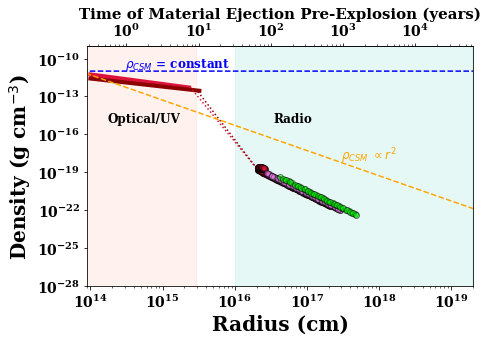

In [136]:
#5 days post explosion


## DENSITY PLOT:
plt.rcParams["font.family"] = "serif"
plt.rcParams.update({'font.size': 15})
plt.rc('xtick',labelsize=14)
plt.rc('ytick',labelsize=14)
figure, subplots = plt.subplots(1, 1, figsize=(7,5))
#figure.rcParams.update({'font.size': 10})


###PUT ON THE SHELL MATERIAL:

#THESE PLOTS LINES FOR THE FOUR MODELS:

#PS11aop: CSM
subplots.plot([1e14,2.32e15],[5.49*10.**(-12),5.03E-13],color='crimson',linewidth=4)

#PS11aop: CSM_NI
subplots.plot([1e14,3.23e15],[2.57*10.**(-12),2.78E-13],color='darkred',linewidth=4)


#THIS WILL FILL IN THE REGION BETWEEN THE MODELS FOR PS1-11vo and PS1-11aop. 

ps11aop_x = [1e14,2.32e15,3.23e15,1e14,1e14]
ps11aop_y = [5.49*10.**(-12),5.03E-13,2.78E-13,2.57*10.**(-12),2.57*10.**(-12)]
subplots.fill(ps11aop_x,ps11aop_y,color='crimson',alpha=1,zorder=2)

#Dashed Lines connecting optical to radio:
subplots.plot([2.39e15,2.2e+16],[5.6155e-13,1e-19],color='crimson',linestyle=':')
subplots.plot([3.09e15,2.2e16],[2.3155e-13,1e-19],color='darkred',linestyle=':')
#subplots.plot([1.22e15,2.60355962868e+16],[3.67668e-13,5.5e-20],color='turquoise',linestyle=':')

### GET ON THE RADIO EMISSION: 

### PS1-11aop EPOCH #1:
#file_in = 'PS11aop_grid_e1+5A.csv'
#data_plot1 = ascii.read(file_in)
#D_L = 1070.1 # distance to SN in Mpc
date_expl =  55770.562 - 5 #55736.161 #inferred explosion date
date_obs = 57307.08 # date that radio obs was taken
redshift = 0.218 # redshift of object
z = 0.218
t_p = (date_obs - date_expl)/(1+redshift) # time of observation in days #1261.509031#

#index2 = np.where(data_plot1['RuledOut'] == 'False')[0]
#data_plot1aa = data_plot1[index2]
indexv1 = (data_plot1aa['v_shock'] <= 20000)
PS11aop_rad1 = data_plot1aa[indexv1]['Radius']
PS11aop_den1 = data_plot1aa[indexv1]['den']

subplots.plot(PS11aop_rad1,PS11aop_den1,'o',color='crimson',alpha=0.5,markeredgecolor='k',lw=3,)
#print(np.min(PS11aop_rad1))

###PS1-11aop e2:
D_L = 1070.1 # distance to SN in Mpc
date_expl =  55770.562 - 5 #55736.161 #inferred explosion date
date_obs2 = 57829.76513 # date that radio obs was taken
redshift = 0.218 # redshift of object

t_p = (date_obs2 - date_expl)/(1+redshift) # time of observation in days #1261.509031#
#file_in1a = 'PS11aop_grid_e2+5A.csv'
#data_plot1a = ascii.read(file_in1a)
#index2b = np.where(data_plot1a['RuledOut'] == 'False')[0]
#data_plot24 = data_plot1a[index2b]
indexv2 = (data_plot24['v_shock'] <= 20000)
PS11aop_rad2 = data_plot24[indexv2]['Radius']
PS11aop_den2 = data_plot24[indexv2]['den']
subplots.plot(PS11aop_rad2,PS11aop_den2,'o',color='violet',alpha=0.5,markeredgecolor='k', lw=3,)

###PS1-11aop e3:
D_L = 1070.1 # distance to SN in Mpc
date_expl =  55770.562 - 5 #55736.161 #inferred explosion date
date_obs3 = 59378.446209 # date that radio obs was taken
redshift = 0.218 # redshift of object

t_p = (date_obs3 - date_expl)/(1+redshift) # time of observation in days #1261.509031#
#file_in3 = 'PS11aop_grid_e3+5A.csv'
#data_plot3 = ascii.read(file_in3)
#index3b = np.where(data_plot3b['RuledOut'] == 'False')[0]
#data_plot2b = data_plot3b[index3b]
indexv3 = (data_plot2b['v_shock'] <= 20000)
PS11aop_rad3 = data_plot2b[indexv3]['Radius']
PS11aop_den3 = data_plot2b[indexv3]['den']
subplots.plot(PS11aop_rad3,PS11aop_den3,'o',color='lime', alpha=0.5,markeredgecolor='k',lw=3,)

### Put on r^-2 wind-like environment and constant CSM:
r = np.arange(start=0.01, stop=20000)*1e15
#den1 = [1e-11,1e-11,1e-11]
import itertools
den1=list(itertools.repeat(1e-11, 20000))
den2 = 5e16*r**(-2)
subplots.plot(r,den2, linestyle = '--', color = 'orange')
subplots.plot(r,den1,linestyle = '--', color = 'blue')


### SHOW THE HIGHLIGHTS OF REGIONS/LABELS: 
r1e = Rectangle((1e13,1e-28),2.9e15,9.999e-10,color='coral',alpha=0.1,zorder=1)
r3e = Rectangle((1e16,1e-28),1.9e+19,9.999e-10,color='xkcd:turquoise',alpha=0.1,zorder=1)
#r5e = Rectangle((1e17,1e-24),6e+17,9.999e-10,color='xkcd:olive',alpha=0.1,zorder=1)
subplots.add_patch(r1e)
subplots.add_patch(r3e)
#subplots.add_patch(r5e)

subplots.set_xscale('log')
subplots.set_yscale('log')
subplots.set_xlabel(r'Radius (cm)', fontsize=20,fontweight ='bold') #Log$_{10}$ t$_{rest}$(days)($\u03BD$ /5 GHz)', fontsize=14)
subplots.set_ylabel(r'Density (g cm$^{-3}$)', fontsize=20,fontweight ='bold') 
#subplots[0].title.set_text('PS1-11aop and PS1-11')   
subplots.title.set_fontsize(16) 
#plot limit
subplots.set_xlim(0.9e14,2e19)
subplots.set_ylim(1e-28,1e-9)

#subplots.text(1.75e14,1e-15,'Dense Shell',fontsize=12,fontweight='bold')
subplots.text(1.75e14,1e-15,'Optical/UV',fontsize=12,fontweight='bold')
subplots.text(3e14,2e-11,r'$\rho_{CSM}$ = constant',fontsize=12,color='blue')

#subplots.text(1.4e16,1e-15,'Wind-like',fontsize=12,fontweight='bold')
subplots.text(3.4e16,1e-15,'Radio',fontsize=12,fontweight='bold')
subplots.text(3e17,1e-18,r'$\rho_{CSM}$ $\propto r^{2}$',fontsize=12,color = 'orange')

#TIME AXIS MANUAL:
#subplots.text(3.1e14,2.5e-10,'1',fontsize=10,fontweight='bold')
#subplots.text(6.3e14,2.5e-10,'2',fontsize=10,fontweight='bold')
#subplots.text(1.5e15,2.5e-10,'5',fontsize=10,fontweight='bold')
#subplots.text(3.1e15,2.5e-10,'10',fontsize=10,fontweight='bold')
#subplots.text(6.3e15,2.5e-10,'20',fontsize=10,fontweight='bold')
#subplots.text(1.5e16,2.5e-10,'50',fontsize=10,fontweight='bold')
#subplots.text(3.1e16,2.5e-10,'100',fontsize=10,fontweight='bold')
#subplots.text(6.3e16,2.5e-10,'200',fontsize=10,fontweight='bold')
#subplots.text(1.3e17,2.5e-10,'500',fontsize=10,fontweight='bold')
#subplots.text(3.1e17,2.5e-10,'1000',fontsize=10,fontweight='bold')
#subplots.text(6.3e17,2.5e-10,'2000',fontsize=10,fontweight='bold')

#subplots.text(4e14,5e-11,'Time of Material Ejection Pre-Explosion (years)',fontsize=11,fontweight='bold')

#bbox={'facecolor': 'k', 'alpha': 0.2, 'pad': 10}

def rad2time(x):
    return x/100e5/86400./365.  #time (years) = radius(cm) /wind speed (100km/s---> 100e5 cm/s)


def time2rad(x):
    return x*365*86400.*100e5   #radius (cm) = time(years) *wind speed

secax = subplots.secondary_xaxis('top', functions=(rad2time, time2rad))
secax.set_xlabel('Time of Material Ejection Pre-Explosion (years)', fontsize =15,fontweight ='bold')
plt.tight_layout()

plt.savefig('densityplot2a5.png',dpi = 500, transparent = True)

plt.show()


In [165]:
# Mass loss rate: optical CSM only
#vw_cgs = 100 * 1e5
#M_cgs =  M * 1e-5 * 6.307e+25
R = (1e14+2.32e15)/2  #cm
d = ((5.49*10.**(-12))+(5.03E-13))/2  #gcm^-3
v = 100 * 1e5 #np.arange(50,1e4)*1e5 cm/s
Mcgs = d*4*np.pi*R**2*v
Msy = Mcgs/6.307e+25  #in solar mass per year
Msy
#(R/v)/86400./365  #time in years

87.41220099602363

In [166]:
# Mass loss rate: optical CSM + Ni
#vw_cgs = 100 * 1e5
#M_cgs =  M * 1e-5 * 6.307e+25
R = (1e14+3.23e15)/2  #cm
d = ((2.57*10.**(-12))+(2.78E-13))/2  #gcm^-3
v = 100 * 1e5 #np.arange(50,1e4)*1e5 cm/s
Mcgs = d*4*np.pi*R**2*v
Msy = Mcgs/6.307e+25  #in solar mass per year
Msy
#(3.23e15/v)/86400./365

7.865484834244807

In [159]:
# Mass loss rate: radio 1st epoch min
#vw_cgs = 100 * 1e5
#M_cgs =  M * 1e-5 * 6.307e+25
R = np.max(data_plot1aa['Radius']) #cm
d = np.min(data_plot1aa['den'])  #gcm^-3
v = 100 * 1e5 #np.arange(50,1e4)*1e5 cm/s
Mcgs = d*4*np.pi*R**2*v
Msy = Mcgs/6.307e+25  #in solar mass per year
Msy
#(R/v)/86400./365 #in years

1.278186057132774e-06

In [160]:
# Mass loss rate: radio 1st epoch max
#vw_cgs = 100 * 1e5
#M_cgs =  M * 1e-5 * 6.307e+25
R = np.min(data_plot1aa['Radius']) #cm
d = np.max(data_plot1aa['den'])  #gcm^-3
v = 100 * 1e5 #np.arange(50,1e4)*1e5 cm/s
Mcgs = d*4*np.pi*R**2*v
Msy = Mcgs/6.307e+25  #in solar mass per year
Msy
#(R/v)/86400./365 #in years


0.00021139507898941203

In [161]:
# Mass loss rate: radio 1st epoch mean
#vw_cgs = 100 * 1e5
#M_cgs =  M * 1e-5 * 6.307e+25
R = np.mean(data_plot1aa['Radius'][indexv1]) #cm
d = np.mean(data_plot1aa['den'][indexv1])  #gcm^-3
v = 100 * 1e5 #np.arange(50,1e4)*1e5 cm/s
Mcgs = d*4*np.pi*R**2*v
Msy = Mcgs/6.307e+25  #in solar mass per year
Msy
#(R/v)/86400./365 #in years

0.0005772035898735736

In [152]:
# Mass loss rate: radio 2nd epoch min
#vw_cgs = 100 * 1e5
#M_cgs =  M * 1e-5 * 6.307e+25
R = np.max(data_plot24['Radius'][indexv2]) #cm
d = np.min(data_plot24['den'][indexv2])  #gcm^-3
v = 100 * 1e5 #np.arange(50,1e4)*1e5 cm/s
Mcgs = d*4*np.pi*R**2*v
Msy = Mcgs/6.307e+25  #in solar mass per year
Msy
#(R/v)/86400./365 #in years

1.6139109436952358e-05

In [153]:
# Mass loss rate: radio 2nd epoch max
#vw_cgs = 100 * 1e5
#M_cgs =  M * 1e-5 * 6.307e+25
R = np.min(data_plot24['Radius'][indexv2]) #cm
d = np.max(data_plot24['den'][indexv2])  #gcm^-3
v = 100 * 1e5 #np.arange(50,1e4)*1e5 cm/s
Mcgs = d*4*np.pi*R**2*v
Msy = Mcgs/6.307e+25  #in solar mass per year
Msy
#(R/v)/86400./365 #in years

0.00012030615861274083

In [154]:
# Mass loss rate: radio 2nd epoch mean
#vw_cgs = 100 * 1e5
#M_cgs =  M * 1e-5 * 6.307e+25
R = np.mean(data_plot24['Radius'][indexv2]) #cm
d = np.mean(data_plot24['den'][indexv2])  #gcm^-3
v = 100 * 1e5 #np.arange(50,1e4)*1e5 cm/s
Mcgs = d*4*np.pi*R**2*v
Msy = Mcgs/6.307e+25  #in solar mass per year
Msy
#(R/v)/86400./365 #in years

0.0002551670987834425

In [155]:
# Mass loss rate: radio 3rd epoch min
#vw_cgs = 100 * 1e5
#M_cgs =  M * 1e-5 * 6.307e+25
R = np.max(data_plot2b['Radius'][indexv3]) #cm
d = np.min(data_plot2b['den'][indexv3])  #gcm^-3
v = 100 * 1e5 #np.arange(50,1e4)*1e5 cm/s
Mcgs = d*4*np.pi*R**2*v
Msy = Mcgs/6.307e+25  #in solar mass per year
Msy
#(R/v)/86400./365 #in years


1.851689223153215e-05

In [156]:
# Mass loss rate: radio 3rd epoch max
#vw_cgs = 100 * 1e5
#M_cgs =  M * 1e-5 * 6.307e+25
R = np.min(data_plot2b['Radius'][indexv3]) #cm
d = np.max(data_plot2b['den'][indexv3])  #gcm^-3
v = 100 * 1e5 #np.arange(50,1e4)*1e5 cm/s
Mcgs = d*4*np.pi*R**2*v
Msy = Mcgs/6.307e+25  #in solar mass per year
Msy
#(R/v)/86400./365 #in years


0.0001385387576502836

In [158]:
# Mass loss rate: radio 3rd epoch mean
#vw_cgs = 100 * 1e5
#M_cgs =  M * 1e-5 * 6.307e+25
R = np.mean(data_plot2b['Radius'][indexv3]) #cm
d = np.mean(data_plot2b['den'][indexv3])  #gcm^-3
v = 100 * 1e5 #np.arange(50,1e4)*1e5 cm/s
Mcgs = d*4*np.pi*R**2*v
Msy = Mcgs/6.307e+25  #in solar mass per year
Msy
#(R/v)/86400./365 #in years

0.0003646038032316044

In [153]:
#2.0708158507681804e+16 4.662443369690785e+16 #cm
print((6.1e-5*65.66513986454149) , (26.5e-5*147.8451093889772)) #solar-mass/yr


0.00400557353173703 0.039178953988078954


In [84]:

from numpy import trapz


In [87]:
radio_timelap = 32205.124712511926 - 66.63684994970943 #for 100 km/s
radio_timelap

32138.487862562215

In [86]:
#total mass lost as inferred by radio data
y = np.array([1.6141202072445873*1e-5, 26.450863693180743*1e-5]) #mass-loss rates at 100km/s

# Compute the area using the composite trapezoidal rule.
area = trapz(y, dx=radio_timelap) #dx is the difference in time during which mass is lost (147.845109388977-65.6651398645414)
print("area =", area)

area = 3.6308941742113596


In [184]:
#total mass lost as inferred by radio data
y = np.array([1.5301758235313847e-06, 26.5e-4]) #mass-loss rates at 1000km/s

# Compute the area using the composite trapezoidal rule.
area = trapz(y, dx=8.2179) #dx is the difference in time during which mass is lost (14.78451093889772-6.566513986454149)
print("area =", area)

area = 0.013395177


In [183]:
14.7845109388977-6.56651398645414

8.21799695244356